In [1]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.model_selection import train_test_split, StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Resize images to 224x224 RGB format and convert them into numpy arrays
arrays = np.array([img_to_array(load_img(f'thia/thia{i}.jpg', target_size=(224, 224))) \
                   if cls == 0 else img_to_array(load_img(f'khaw/khaw{i}.jpg', target_size=(224, 224))) \
                   for cls in range(2) for i in range(1, 51)])

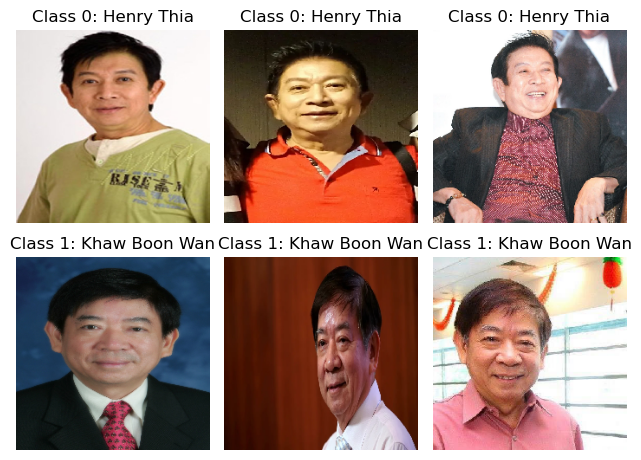

In [3]:
# Display 3 resized images from each class
fig, ax = plt.subplots(2, 3)
for i in range(3):
    ax[0, i].imshow(arrays[i * 12].astype(np.uint8))
    ax[0, i].set_title('Class 0: Henry Thia')
    ax[0, i].axis('off')
for i in range(3):
    ax[1, i].imshow(arrays[i + 50].astype(np.uint8))
    ax[1, i].set_title('Class 1: Khaw Boon Wan')
    ax[1, i].axis('off')
plt.tight_layout()

In [4]:
# Create labels
y = np.concatenate((np.zeros(50), np.ones(50)))

# Train-test split
X, X_test, y, y_test = train_test_split(arrays, y, test_size=0.2, stratify=y, random_state=42)

### Build a baseline model

In [5]:
def build_naive_model():
    model = keras.Sequential([
        layers.Rescaling(scale=1.0/255),
        layers.Conv2D(filters=64, kernel_size=3, input_shape=(224, 224, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(filters=128, kernel_size=3, activation='relu'),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(filters=256, kernel_size=3, activation='relu'),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics='accuracy')
    return model

In [6]:
# Get the optimal number of epochs for the model using cross validation
val_losses = []
train_losses = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_indices, val_indices in skf.split(X, y):
    train_mask = np.zeros(X.shape[0], dtype=bool)
    train_mask[train_indices] = True
    X_train = X[train_mask]
    y_train = y[train_mask]

    val_mask = np.zeros(X.shape[0], dtype=bool)
    val_mask[val_indices] = True
    X_val = X[val_mask]
    y_val = y[val_mask]
    
    model = build_naive_model()
    history = model.fit(X_train, y_train, epochs=100, batch_size=1, validation_data=(X_val, y_val), verbose=0)
    val_losses.append(history.history['val_loss'])
    train_losses.append(history.history['loss'])

del train_mask, val_mask

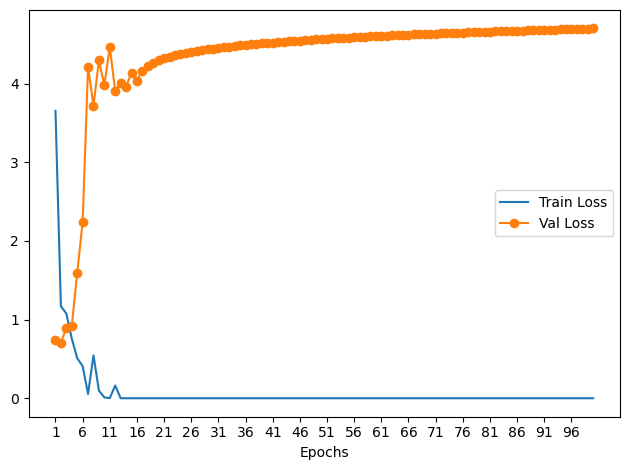

In [7]:
mean_val_losses = [np.mean([x[i] for x in val_losses]) for i in range(100)]
mean_train_losses = [np.mean([x[i] for x in train_losses]) for i in range(100)]

plt.plot(mean_train_losses, label='Train Loss')
plt.plot(mean_val_losses, '-o', label='Val Loss')
plt.xticks(range(0, 100, 5), range(1, 100, 5))
plt.xlabel('Epochs')
plt.tight_layout()
plt.legend();

The model starts overfitting at epoch 3.

In [ ]:
# Evaluate model using epoch 2 and the full training data
scores = []
for i in range(10):
    best_naive_model = build_naive_model()
    best_naive_model.fit(X, y, epochs=2, batch_size=1, verbose=0)
    scores.append(best_naive_model.evaluate(X_test, y_test, verbose=0)[1])

In [9]:
print(f'Average baseline model accuracy: {np.mean(scores):.2f}')

Average baseline model accuracy: 0.47


47% accuracy is the baseline score to beat.

### Build data augmented model

In [10]:
def build_augmented_model():
    model = keras.Sequential([
        layers.RandomFlip("horizontal", input_shape=(224, 224, 3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
        layers.Rescaling(scale=1.0/255),
        layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(filters=128, kernel_size=3, activation='relu'),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(filters=256, kernel_size=3, activation='relu'),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics='accuracy')
    return model

In [ ]:
val_losses = []
train_losses = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_indices, val_indices in skf.split(X, y):
    train_mask = np.zeros(X.shape[0], dtype=bool)
    train_mask[train_indices] = True
    X_train = X[train_mask]
    y_train = y[train_mask]

    val_mask = np.zeros(X.shape[0], dtype=bool)
    val_mask[val_indices] = True
    X_val = X[val_mask]
    y_val = y[val_mask]
    
    model = build_augmented_model()
    history = model.fit(X_train, y_train, epochs=100, batch_size=1, validation_data=(X_val, y_val), verbose=0)
    val_losses.append(history.history['val_loss'])
    train_losses.append(history.history['loss'])

del train_mask, val_mask

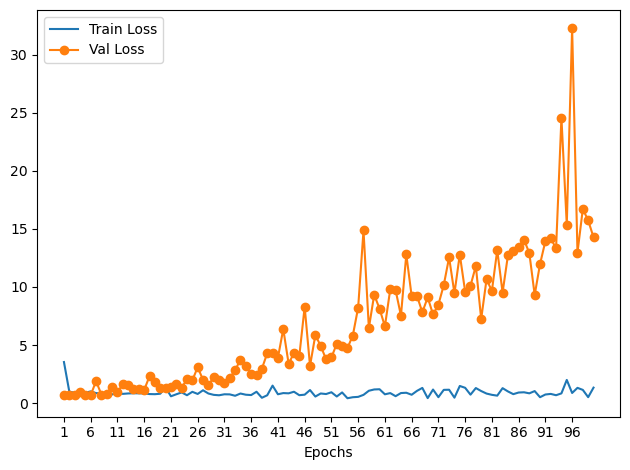

In [12]:
mean_val_losses = [np.mean([x[i] for x in val_losses]) for i in range(100)]
mean_train_losses = [np.mean([x[i] for x in train_losses]) for i in range(100)]

plt.plot(mean_train_losses, label='Train Loss')
plt.plot(mean_val_losses, '-o', label='Val Loss')
plt.xticks(range(0, 100, 5), range(1, 100, 5))
plt.xlabel('Epochs')
plt.tight_layout()
plt.legend();

In [ ]:
# Evaluate using epochs=6
scores = []
for i in range(10):
    best_augmented_model = build_augmented_model()
    best_augmented_model.fit(X, y, epochs=6, batch_size=1, verbose=0)
    scores.append(best_augmented_model.evaluate(X_test, y_test, verbose=0)[1])

In [14]:
print(f'Average augmented model accuracy: {np.mean(scores):.2f}')

Average augmented model accuracy: 0.53


Accuracy improved from 47% to 53%.

### Data augmentation + feature extraction using pre-trained EfficientNetB0 model

In [15]:
# Loading the model
conv_base = keras.applications.EfficientNetB0(weights="imagenet", include_top=False)

preprocessed_train = keras.applications.efficientnet.preprocess_input(X)
preprocessed_test = keras.applications.efficientnet.preprocess_input(X_test)

train_features = conv_base.predict(preprocessed_train)
test_features = conv_base.predict(preprocessed_test)

1/1 [==============================] - 0s 25ms/step


In [16]:
train_features.shape

(80, 7, 7, 1280)

In [17]:
def build_extraction_model():
    model = keras.Sequential([
        layers.RandomFlip("horizontal", input_shape=(7, 7, 1280)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
        layers.Flatten(),
        layers.Dropout(0.5, seed=42),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics='accuracy')
    return model

In [ ]:
val_losses = []
train_losses = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_indices, val_indices in skf.split(train_features, y):
    train_mask = np.zeros(train_features.shape[0], dtype=bool)
    train_mask[train_indices] = True
    X_train = train_features[train_mask]
    y_train = y[train_mask]

    val_mask = np.zeros(train_features.shape[0], dtype=bool)
    val_mask[val_indices] = True
    X_val = train_features[val_mask]
    y_val = y[val_mask]
    
    model = build_extraction_model()
    history = model.fit(X_train, y_train, epochs=100, batch_size=1, validation_data=(X_val, y_val), verbose=0)
    val_losses.append(history.history['val_loss'])
    train_losses.append(history.history['loss'])

del train_mask, val_mask

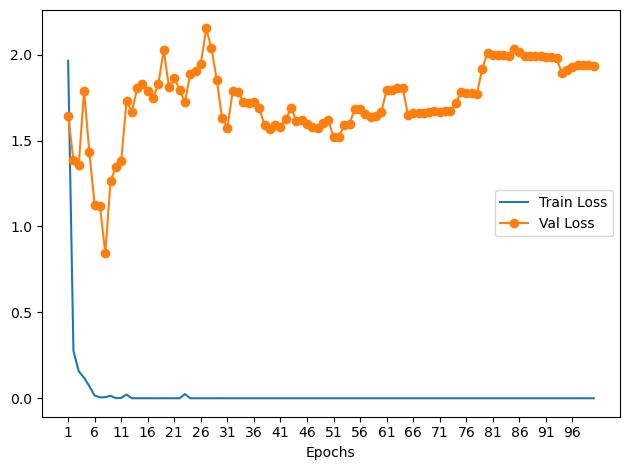

In [28]:
mean_val_losses = [np.mean([x[i] for x in val_losses]) for i in range(100)]
mean_train_losses = [np.mean([x[i] for x in train_losses]) for i in range(100)]

plt.plot(mean_train_losses, label='Train Loss')
plt.plot(mean_val_losses, '-o', label='Val Loss')
plt.xticks(range(0, 100, 5), range(1, 100, 5))
plt.xlabel('Epochs')
plt.tight_layout()
plt.legend();

In [ ]:
# Evaluate model using epochs=8
scores = []
for i in range(10):
    best_extraction_model = build_extraction_model()
    best_extraction_model.fit(train_features, y, epochs=8, batch_size=1, verbose=0)
    scores.append(best_extraction_model.evaluate(test_features, y_test, verbose=0)[1])

In [30]:
print(f'Average extraction model accuracy: {np.mean(scores):.2f}')   

Average extraction model accuracy: 0.83


The accuracy score improved from 53% to 83%, a 36% improvement!

### Fine-tune the EfficientNetB0 model

In [31]:
# Reduce the learning rate of the model with trained top layers
best_extraction_model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=0.0001), metrics='accuracy')

# Save the model
best_extraction_model.save('extracted_model.keras')

In [32]:
conv_base.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_30 (Rescaling)       (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling_30[0][0]']           
                                3)                                                   

In [33]:
# Allow the last 12/16 layers to be trainable
conv_base.trainable = False
for layer in conv_base.layers[-16:]:
    layer.trainable = True

# Freeze batch normalization layers
conv_base.layers[-2].trainable = False
conv_base.layers[-4].trainable = False
conv_base.layers[-12].trainable = False
conv_base.layers[-15].trainable = False

In [ ]:
val_losses = []
train_losses = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_indices, val_indices in skf.split(train_features, y):
    train_mask = np.zeros(train_features.shape[0], dtype=bool)
    train_mask[train_indices] = True
    X_train = train_features[train_mask]
    y_train = y[train_mask]

    val_mask = np.zeros(train_features.shape[0], dtype=bool)
    val_mask[val_indices] = True
    X_val = train_features[val_mask]
    y_val = y[val_mask]
    
    model = keras.models.load_model('extracted_model.keras')
    history = model.fit(X_train, y_train, epochs=100, batch_size=1, validation_data=(X_val, y_val), verbose=0)
    val_losses.append(history.history['val_loss'])
    train_losses.append(history.history['loss'])

del train_mask, val_mask

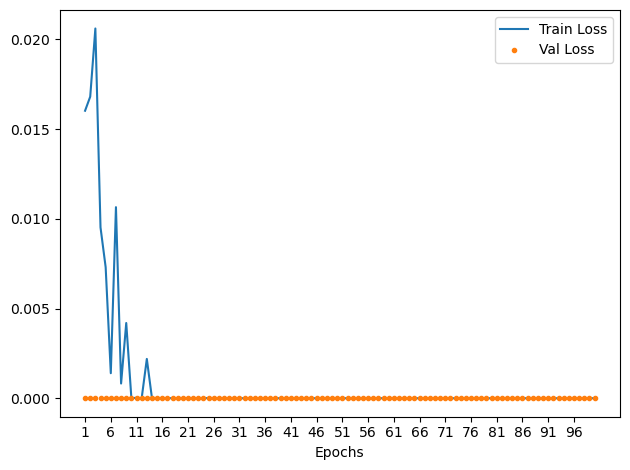

In [35]:
mean_val_losses = [np.mean([x[i] for x in val_losses]) for i in range(100)]
mean_train_losses = [np.mean([x[i] for x in train_losses]) for i in range(100)]

plt.plot(mean_train_losses, label='Train Loss')
plt.plot(mean_val_losses, '.', label='Val Loss')
plt.xticks(range(0, 100, 5), range(1, 100, 5))
plt.xlabel('Epochs')
plt.tight_layout()
plt.legend();

In [ ]:
scores = []
for i in range(10):
    best_ft_model = keras.models.load_model('extracted_model.keras')
    best_ft_model.fit(train_features, y, epochs=21, batch_size=1, verbose=0)
    scores.append(best_ft_model.evaluate(test_features, y_test, verbose=0)[1])  

In [37]:
print(f'Average fine-tuned model accuracy: {np.mean(scores):.2f}')  

Average fine-tuned model accuracy: 0.84


The accuracy score improved from 83% to 84%, which could simply boil down to luck. Given that ImageNet had no relevant classes for the images I'm using, fine-tuning with more layers should yield a better accuracy score.

### Concluding Thoughts
* The random initialisation of weights coupled with a small dataset can result in unreliable model accuracies. One instance can give an accuracy of 0.4 while another gives 0.7. An overcomplex model exacerbates the problem.